In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
print(os.environ)

try:
    import dataretrieval
except ImportError:
    print("dataretrieval not found. Installing...")
    !pip install dataretrieval
    import dataretrieval # Import again after installation

from dataretrieval import nwis # hydrological time-series data from USGS

# Use scikit-learn to grid search the number of neurons
!pip install scikit-learn==1.5.2 # TO AVOID AttributeError: 'super' object has no attribute '__sklearn_tags__'
import sklearn
print(sklearn.__version__)
!pip install hydroeval
import hydroeval as he
from sklearn.model_selection import GridSearchCV  #  hyperparameter tuning
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.constraints import MaxNorm

#!pip install scikeras
#from scikeras.wrappers import KerasRegressor

try:
    from scikeras.wrappers import KerasRegressor
except ImportError:
    print("scikeras not found. Installing...")
    !pip install scikeras
    from scikeras.wrappers import KerasRegressor



import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Imports several common regression evaluation metrics from scikit-learn:
from datetime import datetime
# Get the current time
current_time = datetime.now()
# Print the current time
print("Current time:", current_time)




from numpy import array
!pip install permetrics
from permetrics.regression import RegressionMetric
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
environ({'SHELL': '/bin/bash', 'NV_LIBCUBLAS_VERSION': '12.5.3.2-1', 'NVIDIA_VISIBLE_DEVICES': 'all', 'COLAB_JUPYTER_TRANSPORT': 'ipc', 'NV_NVML_DEV_VERSION': '12.5.82-1', 'NV_CUDNN_PACKAGE_NAME': 'libcudnn9-cuda-12', 'CGROUP_MEMORY_EVENTS': '/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.22.3-1+cuda12.5', 'NV_LIBNCCL_DEV_PACKAGE_VERSION': '2.22.3-1', 'VM_GCE_METADATA_HOST': '169.254.169.253', 'MODEL_PROXY_HOST': 'https://mp.kaggle.net', 'HOSTNAME': 'e5d824f7c624', 'LANGUAGE': 'en_US', 'TBE_RUNTIME_ADDR': '172.28.0.1:8011', 'COLAB_TPU_1VM': '', 'GCE_METADATA_TIMEOUT': '3', 'NVIDIA_REQUIRE_CUDA': 'cuda>=12.5 brand=unknown,driver>=470,driver<471 brand=grid,driver>=470,driver<471 brand=tesla,driver>=470,driver<471 brand=nvidia,driver>=470,driver<471 brand=quadro,driver>=470,driver<471 bran

In [2]:
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
  #'12305000'
#  '12322000'
  #'13092747'
 # '13150430'



#  '13154500'
 # '13176400'
  #"13190500"
 # '13192200'

 # "13211205"
  #'13213000'
#  '13296000'
#  "13307000"
  #'13310800'
 # '13310850'
  #'13311000'
  #'13311250'
  #'13311450'
 # '13317660'


#  "13340000"
  #'13340600'
  #'13341050'
  '13342500'
]

#units_day = 365
#missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
#summer_missing_data_threshold = 0.90 * (30+31+31)

In [3]:
site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va']
filtered_df = site_info_df[columns_to_save]

parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )

dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
# Extracts Date, Month, and Year components from the datetime column.
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year

dailyStreamtemp_df = dailyStreamtemp_df[ ~( (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"] == (2015) ) ) ]

shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

# https://www.tensorflow.org/tutorials/structured_data/time_series
# https://www.scirp.org/journal/paperinformation?paperid=142149
# https://etasr.com/index.php/ETASR/article/view/10595

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)

prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)

prism_df['Date'] = prism_df['date'].dt.date

prism_df = prism_df[['tmean' , "site_no", 'Date','Days_Since_October_1st'
 ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',       'site_no',  '00010_Mean', '00060_Mean'
   ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

# Count the number of NaN values in each column
na_count = result.isna().sum()

# Drop rows with any NaN values
df_cleaned = result.dropna()

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

train_month =  list(range( 4 , 8+1 ))

print("train_month:", train_month)

df_cleaned= df_cleaned[ df_cleaned['Date'].dt.month.isin( train_month )]

print("df_cleaned:",df_cleaned)

print(" df_cleaned.describe():",df_cleaned.describe())

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

print(na_count)

# gap

# Calculate time difference between consecutive dates
df_cleaned['Gap'] = df_cleaned['Date'].diff()

# Filter rows where the gap is more than expected (e.g., > 1 day)
expected_freq = pd.Timedelta(days=1)
gaps = df_cleaned[df_cleaned['Gap'] > expected_freq]

print("gaps",gaps)

site_info_df:   agency_cd   site_no                       station_nm site_tp_cd  lat_va  \
0      USGS  13342500  CLEARWATER RIVER AT SPALDING ID         ST  462654   

   long_va  dec_lat_va  dec_long_va coord_meth_cd coord_acy_cd  ...  \
0  1164939   46.448333    -116.8275             N            S  ...   

  reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  aqfr_type_cd well_depth_va  \
0              C   NNNNNNNN          NaN      NaN           NaN           NaN   

  hole_depth_va depth_src_cd  project_no                    geometry  
0           NaN          NaN         NaN  POINT (-116.8275 46.44833)  

[1 rows x 43 columns]
station_nm: CLEARWATER RIVER AT SPALDING ID
train_month: [4, 5, 6, 7, 8]
df_cleaned:            tmean   site_no       Date  Days_Since_October_1st  00010_Mean  \
1644   12.275001  13342500 2000-04-01                     182         7.3   
1645   12.502001  13342500 2000-04-02                     183         8.0   
1646   15.138000  13342500 2000-04-03       

/tmp/ipython-input-3-3846062343.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


In [4]:
# --- 2. Preprocessing ---
# Select features and target
features = ['tmean',  '00060_Mean' ,"Days_Since_October_1st"]
target = '00010_Mean'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#  the minimum of feature is made equal to zero and the maximum of feature equal to one.
scaler_features = MinMaxScaler(feature_range=(0, 1)) # other scalers like StandardScaler (Z-score normalization) might be more appropriate
scaler_target = MinMaxScaler(feature_range=(0, 1))

print(df_cleaned.shape)
df = df_cleaned.copy()
print(df.shape)
# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))
print("\nDataFrame after Normalization Head:")
print(df.tail())

(3795, 7)
(3795, 7)

DataFrame after Normalization Head:
          tmean   site_no       Date  Days_Since_October_1st  00010_Mean  \
10558  0.493036  13342500 2024-08-27                0.973684    0.445161   
10559  0.443307  13342500 2024-08-28                0.980263    0.412903   
10560  0.543874  13342500 2024-08-29                0.986842    0.425806   
10561  0.660462  13342500 2024-08-30                0.993421    0.438710   
10562  0.734590  13342500 2024-08-31                1.000000    0.438710   

       00060_Mean    Gap  
10558    0.080147 1 days  
10559    0.081194 1 days  
10560    0.081194 1 days  
10561    0.080147 1 days  
10562    0.081194 1 days  


In [5]:
# --- 3. Create Sequences for LSTM ---
# LSTMs require data in a 3D format: (samples, timesteps, features)
# 'timesteps' (also known as look_back) determines how many previous time steps
# the LSTM will consider to predict the next value.

look_back =  60 # You can adjust this based on your data's seasonality/dependencies

def create_sequences(data, look_back, features_cols, target_col):
    X, Y = [], []
    # Ensure data is a numpy array for efficient indexing
    data_np = data[features_cols + [target_col]].values # include target for sequence alignment
    print("data_np:",data_np)
    # Features are the first 'num_features' columns, target is the last column.
    num_features = len(features_cols)

    for i in range(len(data_np) - look_back):
        # X: look_back historical features (x1, x2)
        X.append(data_np[i:(i + look_back +1), :num_features]) # (i + look_back +1) will include the feature of the day of the target
        # Y: the 'y' value at the current time step (i + look_back)
        Y.append(data_np[i + look_back, num_features]) # Target is the last column
    return np.array(X), np.array(Y)

X, Y = create_sequences(df, look_back, features, target)

print("X", X) # did I miss today's X?

# Print first 4 elements
print("First 4 Y elements:", Y[:4])

# Print last 4 elements
print("Last 4 Y elements:", Y[-4:])

print(f"\nShape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of Y (samples, target_value): {Y.shape}")

data_np: [[0.3372352  0.11681509 0.         0.18064516]
 [0.34423147 0.11681509 0.00657895 0.22580645]
 [0.42547438 0.17443688 0.01315789 0.22580645]
 ...
 [0.54387449 0.08119434 0.98684211 0.42580645]
 [0.66046242 0.08014667 0.99342105 0.43870968]
 [0.73459041 0.08119434 1.         0.43870968]]
X [[[0.3372352  0.11681509 0.        ]
  [0.34423147 0.11681509 0.00657895]
  [0.42547438 0.17443688 0.01315789]
  ...
  [0.39536271 0.31272918 0.38157895]
  [0.33782079 0.2750131  0.38815789]
  [0.24717761 0.26034573 0.39473684]]

 [[0.34423147 0.11681509 0.00657895]
  [0.42547438 0.17443688 0.01315789]
  [0.35520357 0.20586695 0.01973684]
  ...
  [0.33782079 0.2750131  0.38815789]
  [0.24717761 0.26034573 0.39473684]
  [0.41684464 0.24567837 0.40131579]]

 [[0.42547438 0.17443688 0.01315789]
  [0.35520357 0.20586695 0.01973684]
  [0.19992972 0.28444212 0.02631579]
  ...
  [0.24717761 0.26034573 0.39473684]
  [0.41684464 0.24567837 0.40131579]
  [0.48770106 0.21320063 0.40789474]]

 ...

 [[0.

In [6]:
# --- 4. Train-Test Split (Time Series Split) ---
# It's crucial to split time series data chronologically to avoid data leakage.
train_size = int(len(X) * 0.8) # e.g., 80% for training, 20% for testing
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f" Y Train samples: {len(Y_train)}")
print(f"Y Test samples: {len(Y_test)}")

Train samples: 2988
Test samples: 747
 Y Train samples: 2988
Y Test samples: 747


In [7]:
#learning_rate = 0.001

def create_model( h1,   d1 , h2, d2,learning_rate ):
    # create model
    model = Sequential()
    model.add(LSTM(units= h1, return_sequences=True , input_shape=(look_back, len(features))))
    model.add(Dropout(  d1 ))  # Dropout to prevent overfitting
    model.add(LSTM(units=h2, return_sequences=False))  # Last LSTM layer
    model.add(Dropout(d2))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
max_epochs =  125

# create model
model = KerasRegressor(model=create_model
                       , epochs=  max_epochs
                       , callbacks=[early_stop]
                      , validation_split=0.2
                       #, batch_size=10
                       #, verbose=0
                       )
print(model.get_params().keys())
print("model:",model)
# define the grid search parameters
h1 = [
      #64 ,
      96 ,128 #,192 #,256
           ]
h2 = [
      #32 ,
      48  ,64 #,96 #, 128
           ]
d1 = [

    #0.1 ,
    0.15,0.2

      ]
d2 = [

    #0.1,
    0.15 ,0.2
       ]
learning_rate=[
   #0.00025,
   0.0005,0.001
    ]
batch_size = [

 #Avoid very small batches (e.g., <8) due to high noise in gradients.

 12 ,16 #,20#,24 #, 28  ,32
               ]

param_grid = dict( model__h1= h1 ,model__d1= d1, model__h2=h2 , model__d2=d2 , model__learning_rate= learning_rate, batch_size=batch_size )
print(param_grid)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose= 2, scoring='neg_mean_squared_error'
                    , cv=3
                    )
print(grid)
grid_result = grid.fit(X_train, Y_train)
print("grid_result:",grid_result)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])
model: KerasRegressor(
	model=<function create_model at 0x790549f81440>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x790548ade090>]
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=125
)
{'model__h1': [96, 128], 'model__d1': [0.15, 0.2], 'model__h2': [48, 64], 'model__d2': [0.15, 0.2], 'model__learning_rate': [0.0005, 0.001], 'batch_size': [12, 16]}
GridSearchCV(cv=3,
             estimator=KerasRegressor(callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x790548ade090>], epochs=125, model=<function create_model at 0x790549f81440>, validation_split=0.2),
         

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/125
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0256 - val_loss: 0.0115
Epoch 2/125
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0098 - val_loss: 0.0071
Epoch 3/125
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0078 - val_loss: 0.0060
Epoch 4/125
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0069 - val_loss: 0.0052
Epoch 5/125
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 6/125
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 7/125
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 8/125
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 9/125
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 10/125
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 11/125
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 12/125
200/200 ━━━━━━━━━━━━━━━━━━━

In [9]:
# --- 8. Make Predictions ---
# Make predictions on the test set
best_params= grid_result.best_params_

print("best_params:",best_params)

#print("best_params:",best_params.keys() )

#print("best_params:",best_params['model__d1'] )

# Enable eager execution
#tf.config.experimental_run_eagerly(True)

best_model = create_model(  best_params['model__h1'], best_params['model__d1'], best_params['model__h2'], best_params['model__d2'] , best_params['model__learning_rate']   )

print(best_model.summary())

# Print the epoch where training stopped
print(f"Training stopped at epoch {early_stop.stopped_epoch + 1}")  # +1 because epochs are 0-i

#best_model = create_model(**{k: best_params[k] for k in ['model__h1', 'model__d1', 'model__h2', 'model__d2' ]})

best_model.fit(X_train, Y_train, epochs=100 # best_params['epochs']
               , callbacks=[early_stop]
               , batch_size=best_params['batch_size']
               )

# Print the epoch where training stopped
print(  "early_stop.stopped_epoch"   , early_stop.stopped_epoch  )

Y_pred_scaled = best_model.predict(X_test)
print(f"\nShape of Y_pred_scaled: {Y_pred_scaled.shape}")
print(f"Shape of Y_test: {Y_test.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Inverse transform the predictions and actual values to the original scale
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_test_original = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

r2 = r2_score( Y_test_original ,  Y_pred )

# Calculate RMSE
all_rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
print(f"Test RMSE: {all_rmse:.4f}")

bias =np.mean( Y_pred- Y_test_original)
print(f"Test bias: { bias:.4f}")

# KGE calculation using hydroeval
# Note: hydroeval's kge function returns KGE, r, alpha, beta by default
# kge_value, r_comp, alpha_comp, beta_comp = he.kge( Y_pred , Y_test_original)
#print( kge_value)

std_ratio = np.std( Y_pred ) / np.std( Y_test_original ) # standard deviation ratio
correlation = np.corrcoef( Y_pred.flatten() ,  Y_test_original.flatten() )[0, 1]
print("correlation", correlation)

print(np.std(Y_pred))
print(np.std(Y_test_original))

best_params: {'batch_size': 12, 'model__d1': 0.15, 'model__d2': 0.2, 'model__h1': 128, 'model__h2': 64, 'model__learning_rate': 0.001}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,057 (457.25 KB)

 Trainable params: 117,057 (457.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Training stopped at epoch 1
Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0247
Epoch 2/100
 25/249 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0112

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0086
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0069
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0062
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0054
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0045
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0043
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0042
Epoch 9/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0039
Epoch 10/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0039
Epoch 11/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0040
Epoch 12/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0037
Epoch 13/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0036
Epoch 14/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0034
Epoch 15/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0032
Epoch 16/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step 

In [10]:
# If training completed all epochs without early stopping,
# stopped_epoch will be -1.

history=best_model.fit(X_train, Y_train, epochs=100
               , callbacks=[early_stop]
               , batch_size=best_params['batch_size']
               )

if early_stop.stopped_epoch != -1:
    best_epoch = early_stop.stopped_epoch - early_stop.patience
    print(f"Training stopped early at epoch {early_stop.stopped_epoch}.")
    print(f"The best model was found at epoch: {best_epoch}")
else:
    print("Training completed all epochs without early stopping.")
    print(f"The training ran for {len(history.history['loss'])} epochs.")
    # In this case, the "best" epoch might be the last one if performance was still improving,
    # or you'd need to manually find the best epoch based on your monitored metric in history.history.
    # For example, if monitoring 'val_loss':
    best_val_loss_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
    print(f"The best validation loss was at epoch: {best_val_loss_epoch}")

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0017
Epoch 2/100
 25/249 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0017
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0016
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0016
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0014
Epoch 9/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0014
Epoch 10/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0014
Epoch 11/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0014
Epoch 12/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013
Epoch 13/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013
Epoch 14/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0014
Epoch 15/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013
Epoch 16/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step 

In [11]:
print("df_cleaned.tail:",df_cleaned.tail)
print((len(Y)-Y_test.shape[0]  ))
print(len(Y) )
dt_ys = df_cleaned.iloc[  ( df_cleaned.shape[0]-Y_test.shape[0]  )  : df_cleaned.shape[0] ]#['Date']

dt_ys['Y_pred'] = Y_pred
dt_ys['Y_test_original']= Y_test_original

dt_ys[['Date','Y_pred', 	'Y_test_original']]

dt_ys['Date'] = pd.to_datetime( dt_ys['Date'])

print( "dt_ys.tail()", dt_ys.tail() )

print( dt_ys['Date'].dt.month.describe())

summer_df = dt_ys[ dt_ys['Date'].dt.month.isin( summer_months)]

print("summer_df.tail()",summer_df.tail())

summer_df.to_csv( '/content/drive/My Drive/LSTM_DOY/LSTM_predictions_DOY_grid_search/'+( model_site[0] + "summer_df_"+current_time.strftime("%Y%m%d%H%M")+".csv") , index=False )


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(summer_df['Y_test_original'], summer_df['Y_pred']))
print(f"Test RMSE: {rmse:.4f}")

df_cleaned.tail: <bound method NDFrame.tail of            tmean   site_no       Date  Days_Since_October_1st  00010_Mean  \
1644   12.275001  13342500 2000-04-01                     182         7.3   
1645   12.502001  13342500 2000-04-02                     183         8.0   
1646   15.138000  13342500 2000-04-03                     184         8.0   
1647   12.858001  13342500 2000-04-04                     185         8.0   
1648    7.820000  13342500 2000-04-05                     186         7.4   
...          ...       ...        ...                     ...         ...   
10558  17.330099  13342500 2024-08-27                     330        11.4   
10559  15.716600  13342500 2024-08-28                     331        10.9   
10560  18.979599  13342500 2024-08-29                     332        11.1   
10561  22.762400  13342500 2024-08-30                     333        11.3   
10562  25.167549  13342500 2024-08-31                     334        11.3   

       00060_Mean    Gap  
1

/tmp/ipython-input-11-1508010932.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_pred'] = Y_pred
/tmp/ipython-input-11-1508010932.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_test_original']= Y_test_original
/tmp/ipython-input-11-1508010932.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [12]:



evaluator = RegressionMetric( [summer_df['Y_test_original']], [summer_df['Y_pred']] )
print(evaluator.nash_sutcliffe_efficiency())




# KGE calculation using hydroeval
# Note: hydroeval's kge function returns KGE, r, alpha, beta by default
kge_value, r_comp, alpha_comp, beta_comp = he.kge( summer_df['Y_pred'].values ,  summer_df['Y_test_original'].values )
print( kge_value)
print( r_comp)
print( alpha_comp)
print( beta_comp)

std_ratio = np.std( summer_df['Y_pred'] ) / np.std( summer_df['Y_test_original'] ) # standard deviation ratio
correlation = np.corrcoef( summer_df['Y_pred']  ,  summer_df['Y_test_original']  )[0, 1]
#correlation = np.corrcoef( summer_df['Y_pred'].flatten() ,  summer_df['Y_test_original'].flatten() )[0, 1]
print("correlation", correlation)







0.6628649482744791
[0.83402611]
[0.84242964]
[1.05167847]
[1.0069462]
correlation 0.842429636651709


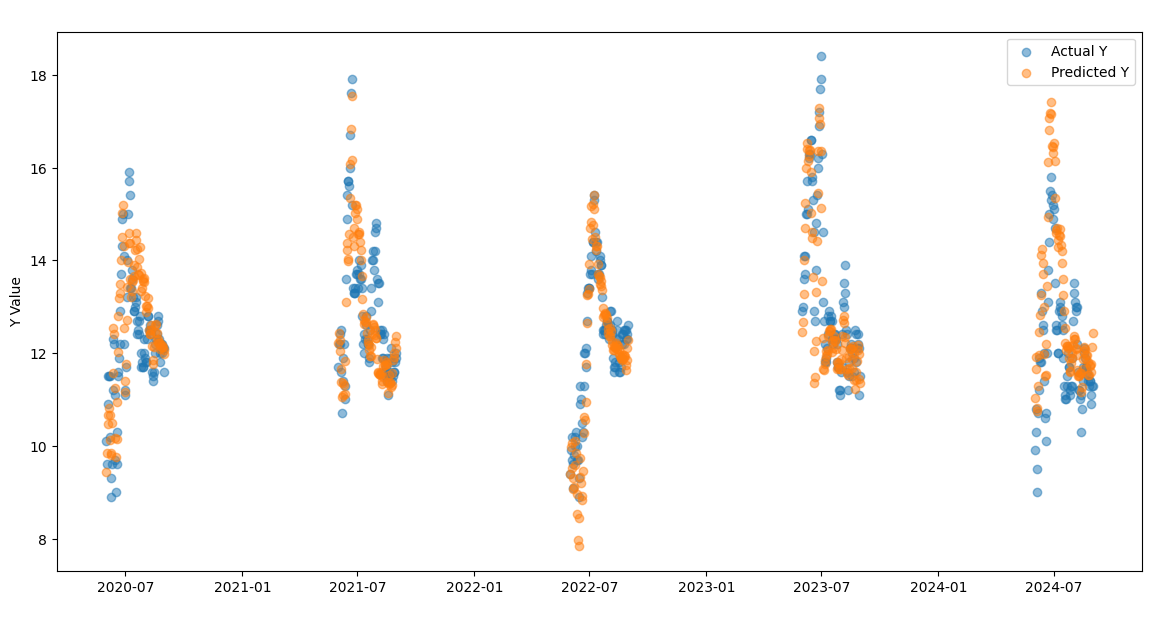

In [13]:
alpha = 0.5

plt.figure(figsize=(14, 7))
plt.scatter(summer_df['Date'], summer_df['Y_test_original'], label='Actual Y',alpha=alpha)
plt.scatter(summer_df['Date'], summer_df['Y_pred'], label='Predicted Y',alpha=alpha)
plt.title(' ')
plt.xlabel(' ')
plt.ylabel('Y Value')
plt.legend()
plt.show()

In [14]:
result_df = pd.DataFrame({
    "current_time":[current_time],
                          "model_site": [model_site[0]],
                          "train_month" : [train_month]
                          , "h1":[ best_params['model__h1']]
                           ,"h1_range":[h1]
                          ,"h2":[ best_params['model__h2'] ]
    ,"h2_range":[h2]
                          ,"d1":[ best_params['model__d1'] ]
    ,"d1_range":[d1]
                          ,"d2":[ best_params['model__d2'] ]
    ,"d2_range":[d2]
                          ,"batch":[ best_params['batch_size']]
    ,"batch_range":[batch_size]
                          ,"look_back":[look_back]


    ,'learning_rate':[ best_params['model__learning_rate'] ]
    ,'learning_rate_range':[learning_rate]
    #,"r2" :[r2]
    ,"NSE" :[ evaluator.nash_sutcliffe_efficiency() ]
    , "rmse":[rmse]
                         #  , "bias":[bias]
                       ,   "std_ratio" :[std_ratio]
                        ,  "correlation" :[correlation]
    ,"KGE" : [kge_value]
,"KGE_r_comp" : [r_comp]
,"KGE_alpha_comp" : [alpha_comp]
,"KGE_beta_comp" : [beta_comp]
    })

print(result_df)




result_df.to_csv('/content/drive/My Drive/LSTM_DOY/LSTM_results_DOY_grid_search/' + model_site[0]+'_result_df_'+   current_time.strftime("%Y%m%d%H%M") + '.csv' , index=False)




                current_time model_site      train_month   h1   h1_range  h2  \
0 2025-06-29 01:06:11.384344   13342500  [4, 5, 6, 7, 8]  128  [96, 128]  64   

   h2_range    d1     d1_range   d2  ... learning_rate  learning_rate_range  \
0  [48, 64]  0.15  [0.15, 0.2]  0.2  ...         0.001      [0.0005, 0.001]   

        NSE      rmse  std_ratio correlation                   KGE  \
0  0.662865  0.919624   1.051678     0.84243  [0.8340261070448427]   

             KGE_r_comp        KGE_alpha_comp       KGE_beta_comp  
0  [0.8424296366517091]  [1.0516784675544173]  [1.00694620243044]  

[1 rows x 24 columns]
